In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#creating dataframe
df=pd.read_csv('hr_employee_churn_data.csv')

In [3]:
df.head()

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,1,0.38,0.53,2,157,3,0,0,low,1
1,2,0.80,0.86,5,262,6,0,0,medium,1
2,3,0.11,0.88,7,272,4,0,0,medium,1
3,4,0.72,0.87,5,223,5,0,0,low,1
4,5,0.37,0.52,2,159,3,0,0,low,1


In [4]:
df.shape

(14999, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14997 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


## feature engineering

In [6]:
df1=df.copy()  #creating copy of original dataframe

In [7]:
df1.drop(['empid'],axis=1,inplace=True)

In [8]:
df1.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,0.38,0.53,2,157,3,0,0,low,1
1,0.80,0.86,5,262,6,0,0,medium,1
2,0.11,0.88,7,272,4,0,0,medium,1
3,0.72,0.87,5,223,5,0,0,low,1
4,0.37,0.52,2,159,3,0,0,low,1


In [9]:
# finding no of missing value
df1.isnull().sum()

satisfaction_level       2
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

In [10]:
# filling missing value by mean value for satisfaction_level
df1['satisfaction_level'].fillna(df1['satisfaction_level'].mean(),inplace=True)

In [11]:
df1.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

###  handling catagorical features

In [12]:
one_hot = pd.get_dummies(df1['salary'], prefix='salary', drop_first=True)
df1 = pd.concat([df1, one_hot], axis=1)
df1.drop(['salary'], axis=1, inplace=True)



In [13]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,0,1,True,False
1,0.80,0.86,5,262,6,0,0,1,False,True
2,0.11,0.88,7,272,4,0,0,1,False,True
3,0.72,0.87,5,223,5,0,0,1,True,False
4,0.37,0.52,2,159,3,0,0,1,True,False


## Split Dataset into Training set and Test set

In [14]:
#split dataset into features and label
X= df1.drop(labels='left',axis=1)
y= df1['left']

In [15]:
# Check for duplicate column names
if X.columns.duplicated().any():
    # Rename columns if duplicates are found
    X.columns = [f'{col}_{i}' if X.columns.duplicated().tolist()[i] else X.columns.tolist()[i] for i, col in enumerate(X.columns)]

In [16]:
#split dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [17]:
len(X_train)

11999

In [18]:
len(X_test)

3000

## Model Selection

In [19]:
#will use two models that are RandomForestClassifier and XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV  # for hyperparameter tunning


In [20]:
model_param = {
    'RandomForestClassifier':{
        'model':RandomForestClassifier(),
        'param':{
            'n_estimators': [10, 50, 100, 130],
            'criterion': ['gini', 'entropy'],
            'max_depth': range(2, 4, 1),
            'max_features': [ 'log2',None]
        }
    },
    'XGBClassifier':{
        'model':XGBClassifier(objective='binary:logistic'),
        'param':{
           'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [3, 5, 10, 20],
            'n_estimators': [10, 50, 100, 200]
        }
    }
}

In [21]:
scores = []
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'], param_grid=mp['param'], cv=3, return_train_score=False, error_score='raise', n_jobs=-1)
    model_selection.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

In [22]:
scores

[{'model': 'RandomForestClassifier',
  'best_score': 0.952462079082483,
  'best_params': {'criterion': 'gini',
   'max_depth': 3,
   'max_features': None,
   'n_estimators': 10}},
 {'model': 'XGBClassifier',
  'best_score': 0.9895329065813163,
  'best_params': {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}}]

## Model Building

In [23]:
#as per above results, xgboost gives best result and hence selecting same to model building...
model_xgb = XGBClassifier(objective='binary:logistic',learning_rate=0.1,max_depth=20,n_estimators=200)


In [24]:
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
model_xgb.score(X_test,y_test)

0.9916666666666667

In [26]:
X_test.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary_low,salary_medium
1670,0.44,0.57,2,141,3,0,0,False,True
13378,0.55,0.96,3,194,3,0,0,False,True
10233,0.72,0.67,5,210,2,0,0,False,True
4719,0.96,0.75,4,177,2,0,0,True,False
7003,0.96,0.54,3,198,3,0,0,True,False


In [27]:

X_test[:1]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary_low,salary_medium
1670,0.44,0.57,2,141,3,0,0,False,True


In [28]:
model_xgb.predict(X_test[:1])

array([1])

In [29]:

df1.loc[1670]

satisfaction_level        0.44
last_evaluation           0.57
number_project               2
average_montly_hours       141
time_spend_company           3
Work_accident                0
promotion_last_5years        0
left                         1
salary_low               False
salary_medium             True
Name: 1670, dtype: object

In [30]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model_xgb.predict(X_test))
cm

array([[2290,    9],
       [  16,  685]], dtype=int64)

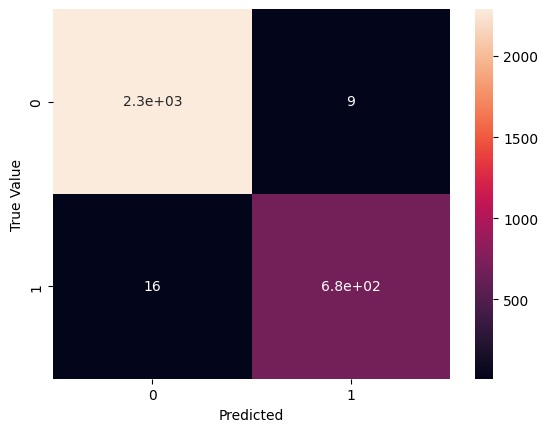

In [31]:
#plot the graph
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.show()